In [1]:
# Import required libraries for data manipulation, visualization and ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# To save the trained model
import pickle


In [2]:
# 2️⃣ Load the CSV data
df = pd.read_csv('weather.csv')

# Convert datetime column to actual datetime object
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)

# Sort by date to maintain time order (important for time-series)
df = df.sort_values('datetime')

# Basic overview
print("Shape of data:", df.shape)
print(df.head())


Shape of data: (1827, 33)
      name   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  Kolkata 2020-01-01     75.4     53.6  64.2          75.4          53.6   
1  Kolkata 2020-01-02     77.1     57.2  66.8          77.1          57.2   
2  Kolkata 2020-01-03     64.4     59.0  62.1          64.4          59.0   
3  Kolkata 2020-01-04     66.2     59.0  62.1          66.2          59.0   
4  Kolkata 2020-01-05     68.0     57.2  61.7          68.0          57.2   

   feelslike   dew  humidity  ...  solarenergy  uvindex  severerisk  \
0       64.2  56.3      76.8  ...         15.6        7         NaN   
1       66.8  59.5      78.7  ...         14.5        7         NaN   
2       62.1  60.5      94.3  ...          5.3        3         NaN   
3       62.1  60.0      92.7  ...          7.8        4         NaN   
4       61.7  59.5      92.5  ...          8.6        4         NaN   

               sunrise               sunset  moonphase  \
0  2020-01-01T06:16:31  20

In [3]:
# Convert temperature values from Fahrenheit to Celsius
df['temp'] = (df['temp'] - 32) * 5/9
df['temp'] = df['temp'].round(2)  # Optional: round for neatness


In [4]:
# 3️⃣ Feature Engineering: Create useful features for learning

# Extract time-based features (seasonality)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# Create lag features (previous day's info)
df['temp_lag1'] = df['temp'].shift(1)
df['humidity_lag1'] = df['humidity'].shift(1)
df['pressure_lag1'] = df['sealevelpressure'].shift(1)

# Create rolling averages (smooth out short-term noise)
df['temp_3day_avg'] = df['temp'].rolling(3).mean().shift(1)
df['humidity_3day_avg'] = df['humidity'].rolling(3).mean().shift(1)
df['pressure_3day_avg'] = df['sealevelpressure'].rolling(3).mean().shift(1)

# Target variable: Temperature of the next day
df['target_temp'] = df['temp'].shift(-1)


In [5]:
# 4️⃣ Drop any rows with NaN values created by shift/rolling
df.dropna(inplace=True)

# Double-check final columns
print("Final features after preprocessing:\n", df.columns)


Final features after preprocessing:
 Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations',
       'year', 'month', 'day', 'dayofweek', 'temp_lag1', 'humidity_lag1',
       'pressure_lag1', 'temp_3day_avg', 'humidity_3day_avg',
       'pressure_3day_avg', 'target_temp'],
      dtype='object')


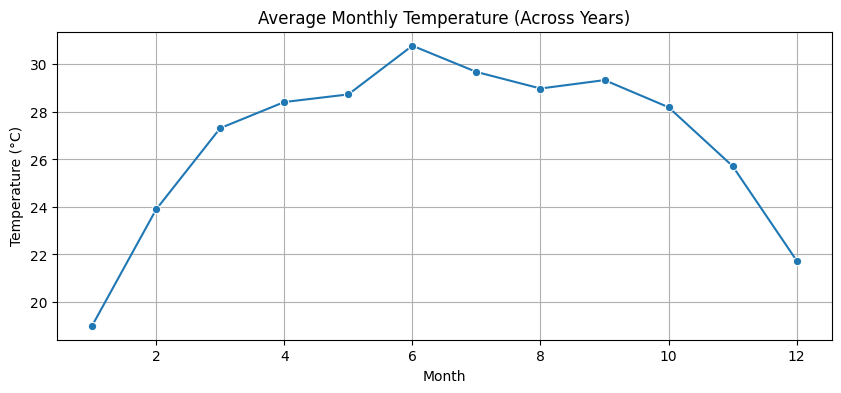

c:\Users\Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


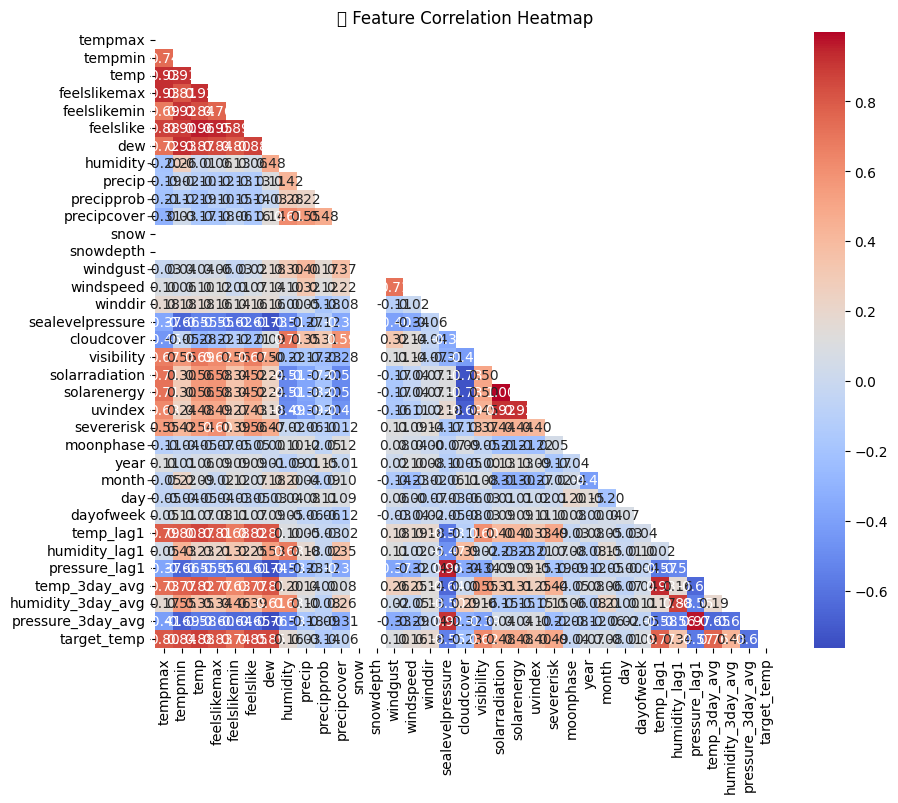

In [6]:
# Ensure datetime is in correct format and extract 'month' column
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
if 'month' not in df.columns:
    df['month'] = df['datetime'].dt.month

# 📈 Plot average monthly temperature
plt.figure(figsize=(10, 4))
sns.lineplot(x='month', y='temp', data=df,errorbar=None, marker='o')
plt.title("Average Monthly Temperature (Across Years)")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()

# 🔥 Correlation Heatmap
import numpy as np  # 🧠 Ensure this is imported once at the top

# ✅ Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# ✅ Create correlation matrix
corr = numeric_df.corr()

# ✅ Optional: mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# ✅ Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔥 Feature Correlation Heatmap")
plt.show()


c:\Users\Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


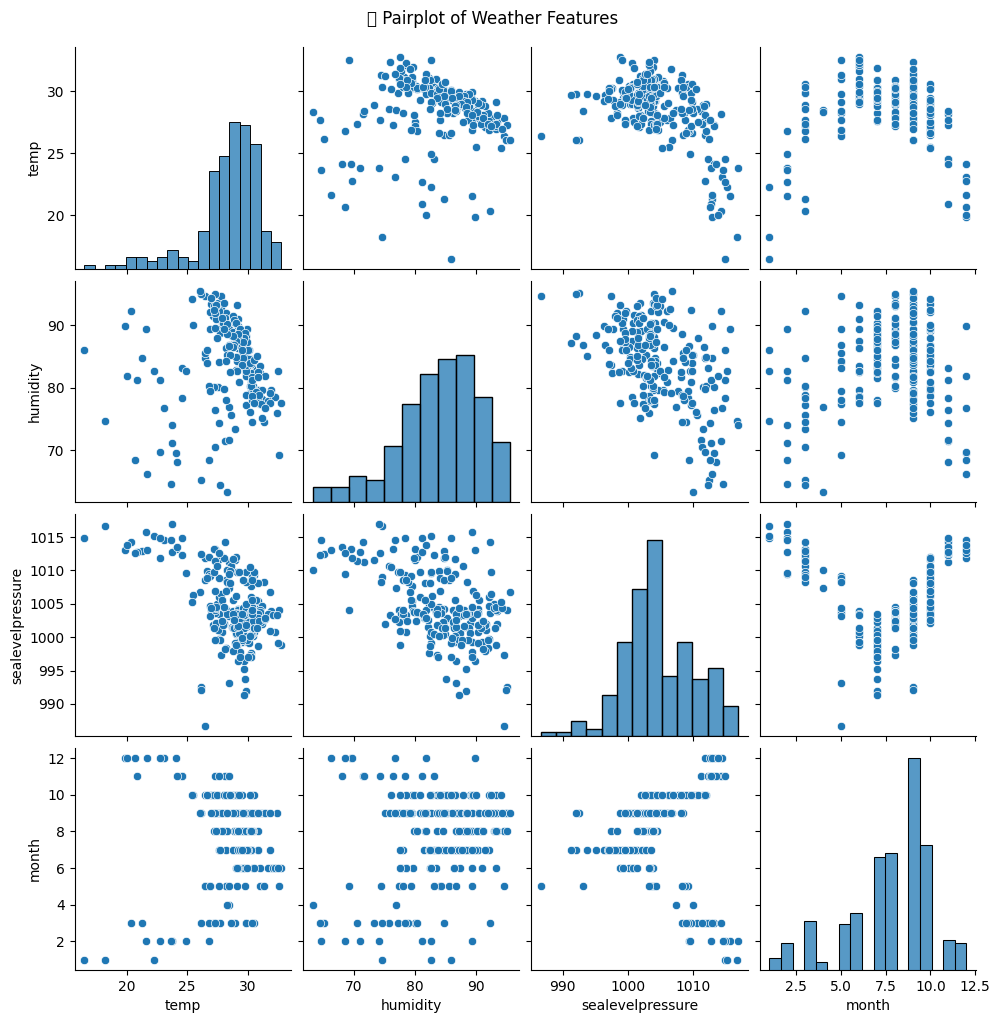

In [7]:
sns.pairplot(df[['temp', 'humidity', 'sealevelpressure', 'month']])
plt.suptitle("🔗 Pairplot of Weather Features", y=1.02)
plt.show()


C:\Users\Islam\AppData\Local\Temp\ipykernel_12040\3791574681.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


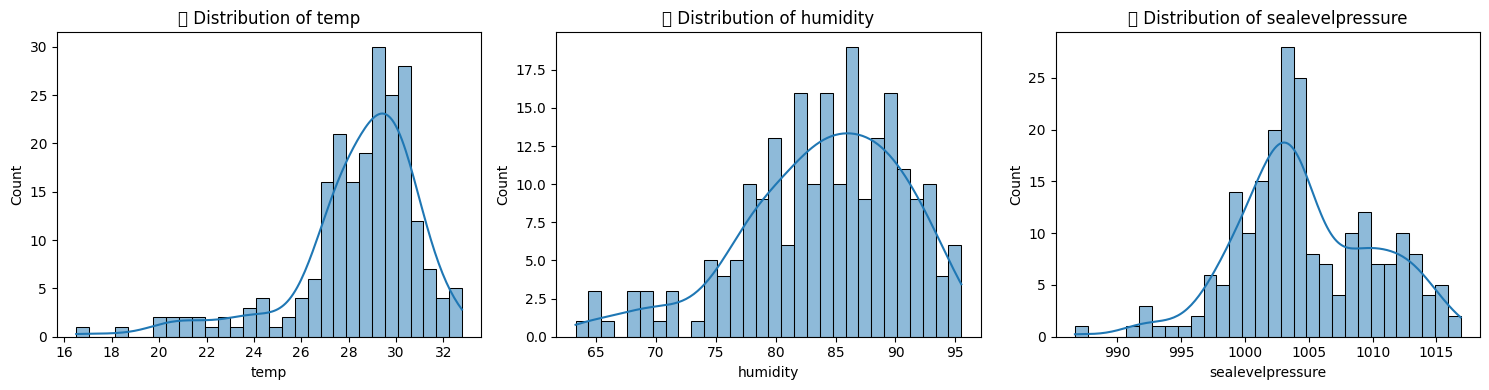

In [8]:
features = ['temp', 'humidity', 'sealevelpressure']

plt.figure(figsize=(15, 4))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"📊 Distribution of {col}")
plt.tight_layout()
plt.show()


c:\Users\Islam\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


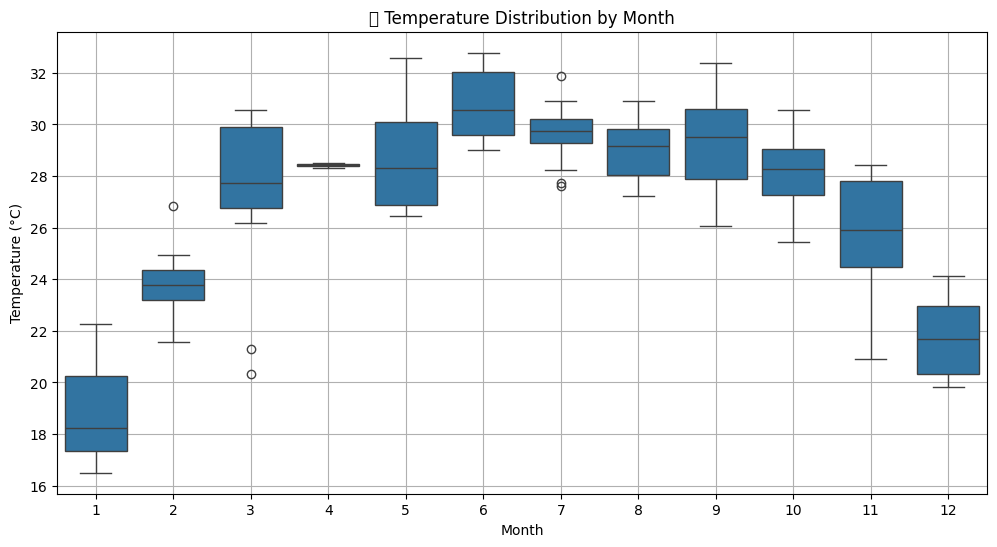

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp', data=df)
plt.title("📦 Temperature Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()


In [10]:
# Define the feature columns
features = [
    'temp', 'humidity', 'sealevelpressure',
    'temp_lag1', 'humidity_lag1', 'pressure_lag1',
    'temp_3day_avg', 'humidity_3day_avg', 'pressure_3day_avg',
    'month', 'day', 'dayofweek'
]

# Drop rows where any of the input features or the target are NaN
df = df.dropna(subset=features + ['target_temp'])


In [11]:
# Now define X and y using the cleaned dataframe
X = df[features]
y = df['target_temp']


In [12]:
# Split the dataset into training and testing sets (without shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training on:", len(X_train), "samples")
print("Testing on:", len(X_test), "samples")


Training on: 173 samples
Testing on: 44 samples


In [13]:
# Train the model (Random Forest is a great choice for regression tasks)
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [14]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Evaluation:")
print(f"MAE: {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
print(f"R² Score: {r2:.2f}")


📊 Model Evaluation:
MAE: 1.16 °C
RMSE: 1.49 °C
R² Score: 0.75


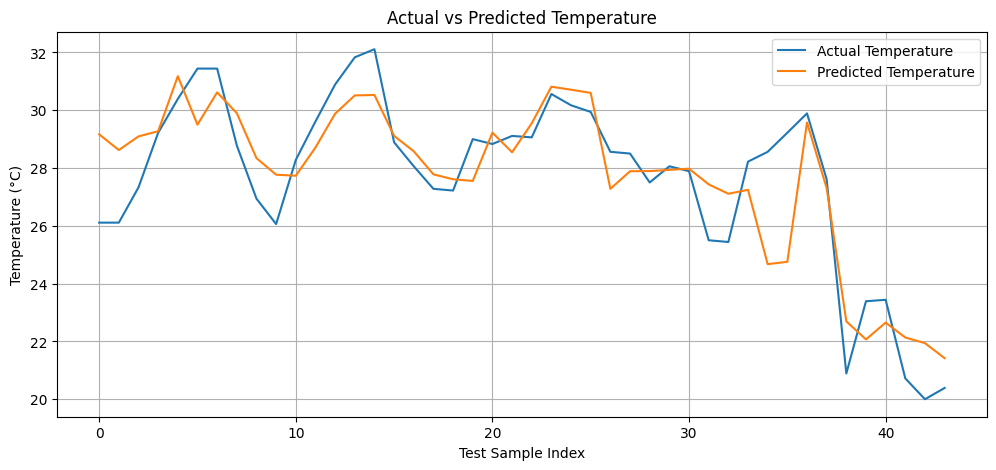

In [15]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.legend()
plt.title('Actual vs Predicted Temperature')
plt.xlabel("Test Sample Index")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()


In [16]:
df[['temp', 'humidity', 'sealevelpressure']].describe()


,temp,humidity,sealevelpressure
count,217.000000,217.000000,217.000000
mean,28.400737,83.951613,1004.722120
std,2.663751,6.749370,5.421986
min,16.500000,63.300000,986.700000
25%,27.500000,79.800000,1001.400000
50%,29.000000,84.700000,1003.900000
75%,30.110000,89.100000,1008.900000
max,32.780000,95.500000,1016.900000


In [17]:
# Save the trained model to .pkl for use in Flask app
with open('weather_prediction_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("✅ Model saved as 'weather_prediction_model.pkl'")


✅ Model saved as 'weather_prediction_model.pkl'
